Stack Overflow dataset
* 4 classes (Python, CSharp, JavaScript, Java)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import string
import os
import re

from tensorflow.keras import layers, losses, metrics

In [12]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
dataset_file = tf.keras.utils.get_file(origin=dataset_url, untar=False, cache_dir='./data/', cache_subdir='stack_overflow')
data_path = os.path.dirname(dataset_file)

'./data/stack_overflow'

In [13]:
train_dir = os.path.join(data_path, 'train')
test_dir = os.path.join(data_path, 'test')

In [14]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [15]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ] 

In [16]:
def custom_standardization(input_data):
    text = tf.strings.lower(input_data)
    text = tf.strings.regex_replace(text, '<br />', ' ')
    text = tf.strings.regex_replace(text,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

    # Remove non-ASCII characters
    # text = tf.strings.regex_replace(text, r'[^\x00-\x7F]+', ' ')

    # for stopword in stopwords:
    #     text = tf.strings.regex_replace(text, f'\\b{stopword}\\b', '')
     
    return text

In [17]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_sequence_length=sequence_length)

In [18]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [19]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [20]:
text_batch, label_batch = next(iter(raw_train_ds))
review, label = text_batch[0], label_batch[0]

print(f'Review:\n{review}')
print(f'\nStandardization:\n{custom_standardization(review)}')
print(f'\nLabel: {label}')
print(f'\nVectorized review:\n{vectorize_text(review, label)}')

Review:
b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n'

Standardization:
b'unit testing of setters and getters teacher wanted us to do a comprehensive unit test for me this will be the first time that i use junit i am confused about testing set and get methods do you think should i test them if the answer is yes is this code enough for testing  public void testsetandget    int a  10    class firstclass  new class    firstclasssetvalue10    int

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [22]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [23]:
embedding_dim = 16

In [25]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
__________________________________________________

In [26]:
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/15
200/200 [==============================] - 2s 9ms/step - loss: 0.7869 - accuracy: 0.7894 - val_loss: 0.8003 - val_accuracy: 0.7719
Epoch 2/15
200/200 [==============================] - 2s 9ms/step - loss: 0.7436 - accuracy: 0.7983 - val_loss: 0.7650 - val_accuracy: 0.7781
Epoch 3/15
200/200 [==============================] - 2s 9ms/step - loss: 0.7024 - accuracy: 0.8098 - val_loss: 0.7346 - val_accuracy: 0.7850
Epoch 4/15
200/200 [==============================] - 2s 9ms/step - loss: 0.6703 - accuracy: 0.8184 - val_loss: 0.7082 - val_accuracy: 0.7881
Epoch 5/15
200/200 [==============================] - 2s 9ms/step - loss: 0.6382 - accuracy: 0.8266 - val_loss: 0.6834 - val_accuracy: 0.7912
Epoch 6/15
200/200 [==============================] - 2s 9ms/step - loss: 0.6095 - accuracy: 0.8353 - val_loss: 0.6618 - val_accuracy: 0.7944
Epoch 7/15
200/200 [==============================] - 2s 9ms/step - loss: 0.5823 - accuracy: 0.8422 - val_loss: 0.6428 - val_accuracy: 0.8012
Epoch 

In [29]:
loss, accuracy = model.evaluate(test_ds)

print('Loss: ', loss)
print('Accuracy: ', accuracy)

250/250 [==============================] - 12s 46ms/step - loss: 0.5896 - accuracy: 0.7936
Loss:  0.589563250541687
Accuracy:  0.793624997138977


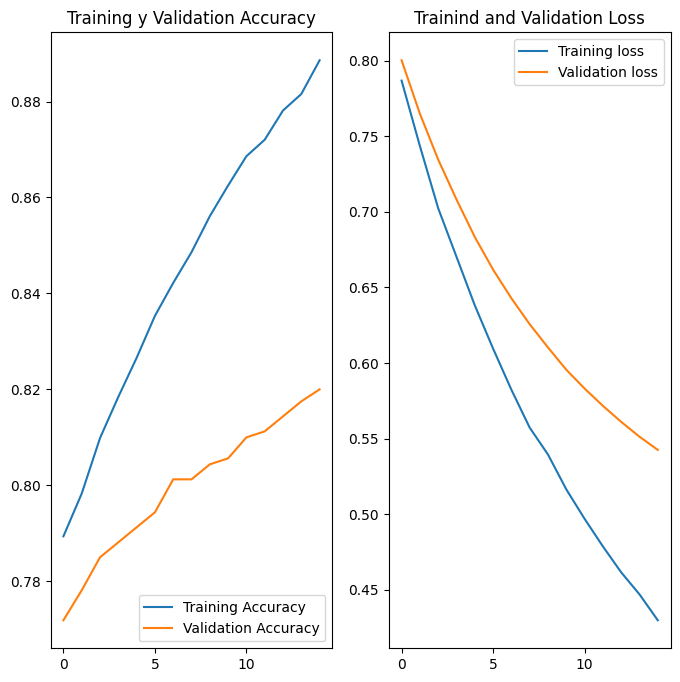

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training y Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Trainind and Validation Loss')
plt.show()

## Export the Model

In [33]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('softmax')])

export_model.compile(optimizer='adam', 
                     loss=losses.SparseCategoricalCrossentropy(from_logits=False), 
                     metrics=['accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 3s 11ms/step - loss: 0.5896 - accuracy: 0.7936
0.793624997138977


## Inference on new data

In [35]:
examples = [
  "The movie was python!",
  "The movie was java.",
  "The movie was csharp..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 79ms/step


array([[0.27950132, 0.25587738, 0.3102678 , 0.1543535 ],
       [0.26506984, 0.21331285, 0.3552123 , 0.166405  ],
       [0.30908588, 0.23147349, 0.29152867, 0.16791198]], dtype=float32)